## Etape 1: récupérez les données et commencez à les regarder 

1. Créez une base sqlite localement
2. Créez deux tables et uploadez les données
3. Récupérez les tables sous forme de dataframe python et faites une exploration rapide de ces données.
4. Quels sont selon vous dans les données patients les données personnelles (identificateurs & quasi-identificateurs) et les données sensibles ?
5. De combien de patients retrouvez vous le nom en faisant une jointure entre ces deux tables ?

### Soluce

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sqlite3
from datetime import date
from dateutil.relativedelta import relativedelta

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

from anonymity.mondrian import MondrianAnonymizer, is_k_anonymous

sns.set_style("whitegrid")

1. Créez une base sqlite localement

In [2]:
db_filepath = Path('tp_anonymisation.db')
db_filepath.unlink(missing_ok=True) # rm db if exists

In [3]:
conn = sqlite3.connect(db_filepath)
c = conn.cursor()

2. Créez deux tables et uploadez les données

Avec sqlite3

```
.separator ;
.import personal_data.csv personal_data
.import sensitive_data.csv sensitive_data
.mode list
```

Avec python / pandas

In [4]:
items_to_feed = [('personal_data.csv', 'personal_data'),
                 ('sensitive_data.csv', 'sensitive_data')]

for filepath, table_name in items_to_feed:
    pd.read_csv(filepath, sep=';')\
        .to_sql(table_name, conn, if_exists='replace', index=False)

Récupérez les tables sous forme de dataframe python et faites une exploration rapide de ces données.

In [5]:
q = '''
select *
from sensitive_data
'''
df_sdata = pd.read_sql(q, conn)

Nombre de patients dans notre fichier de données:

In [6]:
len(df_sdata)

1077

In [7]:
df_sdata.head()

,nom,prenom,sexe,age,date_naissance,adresse,code_postal,maladies_cardiaques,diabete,cancers,maternite
0,ABBAL,FRANÇOIS,1,64,1957-04-16,34 Chemin des Charbottes 69009 Lyon 9e Arrondi...,69009,1,0,0,0
1,ADAM,CÉCILE,2,50,1971-01-30,4 Chemin du Recou 69520 Grigny,69520,0,0,1,1
2,ADIASSE,LAURENCE,2,69,1952-06-25,413 Allée du 11 Novembre 1918 69300 Caluire-et...,69300,0,0,0,0
3,AFCHAIN,ELISE,2,82,1938-10-26,2 Place Jean Moulin 69800 Saint-Priest,69800,0,0,0,0
4,AGNEL,MURIEL,2,88,1933-06-10,82 Rue Sully 69006 Lyon 6e Arrondissement,69006,0,1,0,0


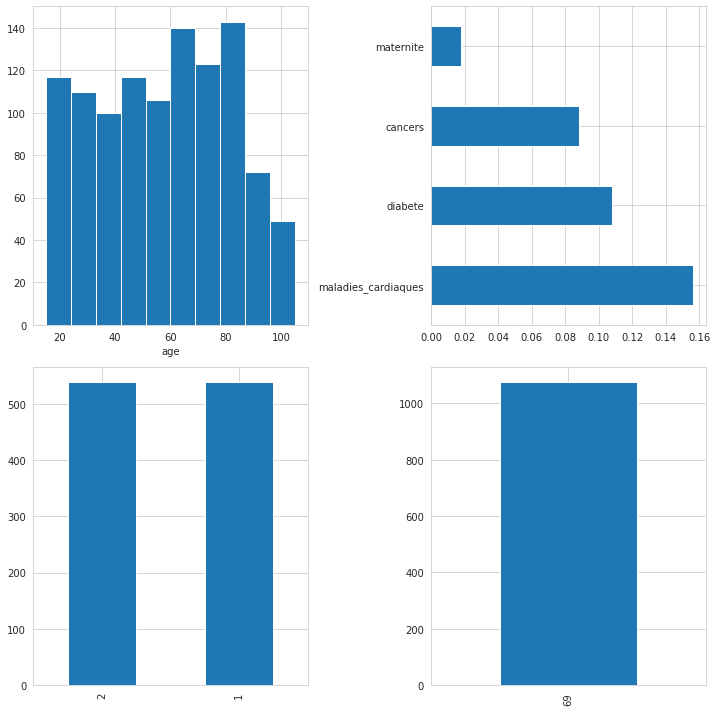

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# age distribution
ax00 = ax[0, 0]
df_sdata['age'].hist(ax=ax00)
ax00.set_xlabel('age')

# prevalence of each disease in the population
ax01 = ax[0, 1]
sensitive_cols = ['maladies_cardiaques', 'diabete', 'cancers', 'maternite']
df_sdata[sensitive_cols].mean().plot(ax=ax01, kind='barh')

# sex "ratio"
ax10 = ax[1, 0]
df_sdata['sexe'].value_counts().plot(ax=ax10, kind='bar')

# repartition according to department
ax11 = ax[1, 1]
df_sdata['code_postal'].apply(lambda x: str(x)[:2]).value_counts().plot(ax=ax11, kind='bar')

fig.tight_layout()

In [9]:
q = '''
select *
from personal_data
'''
df_pdata = pd.read_sql(q, conn)

Nombre de personnes dans notre fichier de données marketting:

In [10]:
len(df_pdata)

100000

In [11]:
df_pdata.head()

,nom,prenom,sexe,age,adresse,code_postal
0,REINERS,MICKAELLE,2,47,60 Place de l’Eglise 69830 Saint-Georges-de-Re...,69830
1,WURRY,LIA,2,55,8 Rue Sainte Barbe 69210 Saint-Pierre-la-Palud,69210
2,SCHELCHER,GINETTE,2,82,148 Boulevard de l’Europe 69310 Pierre-Bénite,69310
3,LARNAUDIE EIFFEL,ANGELIQUE,2,78,7 Rue Paul Verlaine 69100 Villeurbanne,69100
4,THOMILA,NABIL,1,50,2 Rue de la Brévenne 69210 L'Arbresle,69210


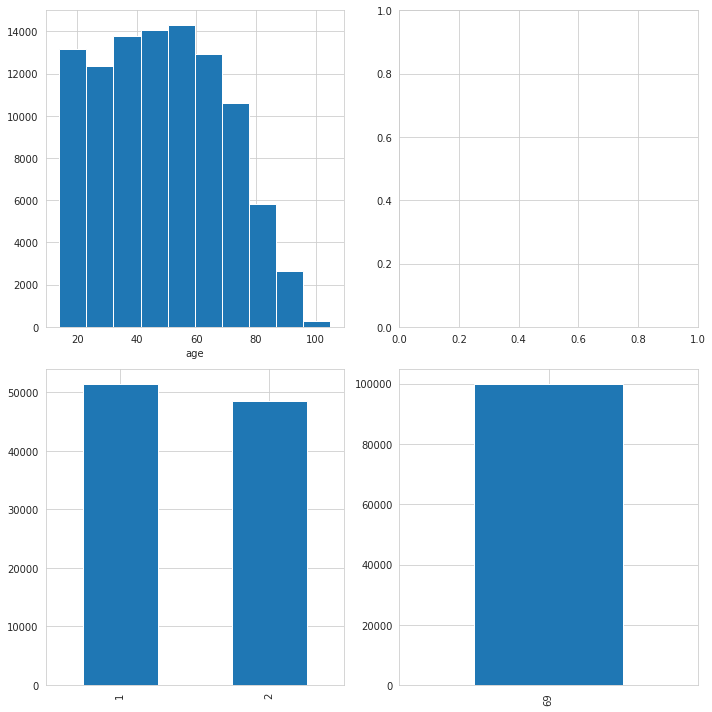

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# age distribution
ax00 = ax[0, 0]
df_pdata['age'].hist(ax=ax00)
ax00.set_xlabel('age')

# sex "ratio"
ax10 = ax[1, 0]
df_pdata['sexe'].value_counts().plot(ax=ax10, kind='bar')

# repartition according to department
ax11 = ax[1, 1]
df_pdata['code_postal'].apply(lambda x: str(x)[:2]).value_counts().plot(ax=ax11, kind='bar')

fig.tight_layout()

4. Quels sont selon vous dans les données patients les données personnelles (identificateurs & quasi-identificateurs) et les données sensibles ?
5. De combien de patients retrouvez vous le nom en faisant une jointure entre ces deux tables ?

In [13]:
q = '''
select sdata.*
from sensitive_data as sdata
inner join personal_data as pdata
on pdata.nom = sdata.nom and pdata.prenom = sdata.prenom and pdata.adresse = sdata.adresse;
'''
df_join = pd.read_sql(q, conn)

Nombre de patients de notre fichier de données qui correspondent (nom, prenom, adresse) à des personnes issues du fichier de données marketting:

In [14]:
len(df_join)

981

In [15]:
df_join.head()

,nom,prenom,sexe,age,date_naissance,adresse,code_postal,maladies_cardiaques,diabete,cancers,maternite
0,ABBAL,FRANÇOIS,1,64,1957-04-16,34 Chemin des Charbottes 69009 Lyon 9e Arrondi...,69009,1,0,0,0
1,ADAM,CÉCILE,2,50,1971-01-30,4 Chemin du Recou 69520 Grigny,69520,0,0,1,1
2,ADIASSE,LAURENCE,2,69,1952-06-25,413 Allée du 11 Novembre 1918 69300 Caluire-et...,69300,0,0,0,0
3,AFCHAIN,ELISE,2,82,1938-10-26,2 Place Jean Moulin 69800 Saint-Priest,69800,0,0,0,0
4,AGNEL,MURIEL,2,88,1933-06-10,82 Rue Sully 69006 Lyon 6e Arrondissement,69006,0,1,0,0


In [16]:
# attention aux homonymes
q = '''
select sdata.*
from sensitive_data as sdata
inner join personal_data as pdata
on pdata.nom = sdata.nom and pdata.prenom = sdata.prenom and pdata.adresse = sdata.adresse
group by pdata.nom, pdata.prenom, pdata.adresse
having count(*) > 1
'''
pd.read_sql(q, conn)

,nom,prenom,sexe,age,date_naissance,adresse,code_postal,maladies_cardiaques,diabete,cancers,maternite


Nombre de patients de notre fichier de données qui correspondent (nom, prenom, adresse) à des personnes issues du fichier de données marketting (sans ambiguité):

In [17]:
len(df_join)

981

## Etape 2: Pseudonymisez vos données puis attaquez les

1. Supprimer les identificateurs et les remplacer par une valeur unique par patient.
2. Chargez les données pseudonymisées. Combien d'individus vous arrivez à identifier de manière unique et pour combien retrouvez vous le nom et le prénom ?
    * Quelles sont selon vous les limites de la pseudonymisation ?
    * Que feriez vous pour améliorer cette approche ?
3. Mettez en oeuvre vos idées. Pour rappel, dans le cadre de votre étude, il vous faut conserver au minimum sujet des patients:
    * une idée de l'âge
    * le genre
    * une idée de la localisation géographique

### Soluce

1. Supprimer les identificateurs et les remplacer par une valeur unique par patient.

In [18]:
del df_join['nom']
del df_join['prenom']

2. Chargez les données pseudonymisées. Combien d'individus vous arrivez à identifier de manière unique et pour combien retrouvez vous le nom et le prénom ?
    * Quelles sont selon vous les limites de la pseudonymisation ?
    * Que feriez vous pour améliorer cette approche ?

In [19]:
q = '''
create table  IF NOT EXISTS sensitive_data_pseudo
as 
select sexe,
       age,
       adresse,
       code_postal,
       date_naissance,
       maladies_cardiaques,
       diabete,
       cancers,
       maternite
       from sensitive_data 

'''
c.execute(q)
conn.commit()

In [20]:
q = '''
select *
from sensitive_data_pseudo 
group by age, sexe, adresse
having count(*) == 1
'''

df_sdata_pseudo = pd.read_sql(q, conn)

In [21]:
df_sdata_pseudo

,sexe,age,adresse,code_postal,date_naissance,maladies_cardiaques,diabete,cancers,maternite
0,1,15,21 Rue André Bonin 69004 Lyon 4e Arrondissement,69004,2006-01-04,0,0,0,0
1,1,15,243 Avenue Général Frère 69008 Lyon 8e Arrondi...,69008,2006-02-23,0,0,0,0
2,1,15,27 Rue Bellecordière 69002 Lyon 2e Arrondissement,69002,2005-11-18,0,0,0,0
3,1,15,5 Rue du Canal 69100 Villeurbanne,69100,2005-10-03,0,0,0,0
4,1,15,61 Rue Baraban 69003 Lyon 3e Arrondissement,69003,2005-06-19,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1072,2,101,21 Rue Claude Boyer 69007 Lyon 7e Arrondissement,69007,1919-10-07,0,0,0,0
1073,2,101,8 Rue d’Auvergne 69320 Feyzin,69320,1920-01-19,1,0,0,0
1074,1,102,105 Impasse du Plein Ouest 69210 Bully,69210,1919-01-25,1,0,0,0
1075,1,102,169 Route du Bluizard 69460 Saint-Étienne-la-V...,69460,1918-11-05,1,1,1,0


In [22]:
q = '''
with all_matches as (
select pdata.nom,
       pdata.prenom,
       sdata.*
from sensitive_data_pseudo as sdata
inner join personal_data as pdata
on pdata.age = sdata.age and pdata.adresse = sdata.adresse and pdata.sexe = sdata.sexe
)
select *
from all_matches
group by age, adresse, sexe
having count(*) == 1
'''
df_pseudo_identified = pd.read_sql(q, conn)

Nombre de patients de notre fichier de données pseudonymisé qui correspondent (nom, prenom, adresse) à des personnes issues du fichier de données marketting (sans ambiguité):

In [23]:
len(df_pseudo_identified)

978

In [24]:
q = '''
with all_matches as (
select pdata.nom,
       pdata.prenom,
       sdata.*
from sensitive_data_pseudo as sdata
inner join personal_data as pdata
on pdata.age = sdata.age and pdata.adresse = sdata.adresse and pdata.sexe = sdata.sexe
),

ambiguous as (
select age, adresse, sexe
from all_matches
group by age, adresse, sexe
having count(*) > 1
)
select sensitive_data_pseudo.*
from sensitive_data_pseudo
join ambiguous
on sensitive_data_pseudo.age = ambiguous.age and sensitive_data_pseudo.sexe = ambiguous.sexe and sensitive_data_pseudo.adresse = ambiguous.adresse
'''
df_pseudo_unidentified = pd.read_sql(q, conn)

In [25]:
df_pseudo_unidentified

,sexe,age,adresse,code_postal,date_naissance,maladies_cardiaques,diabete,cancers,maternite
0,1,44,300 Cours Emile Zola 69100 Villeurbanne,69100,1977-01-12,0,0,0,0
1,1,50,7 Rue Philippe de Lassalle 69004 Lyon 4e Arron...,69004,1970-10-15,0,1,0,0
2,2,55,15 Rue de Normandie 69330 Meyzieu,69330,1966-05-11,0,0,0,0


3. Mettez en oeuvre vos idées. Pour rappel, dans le cadre de votre étude, il vous faut conserver au minimum sujet des patients:
    * une idée de l'âge
    * le genre
    * une idée de la localisation géographique

In [26]:
df_sensitive_pseudo = pd.read_sql('select * from sensitive_data_pseudo', conn)

In [27]:
s_age = df_sensitive_pseudo['age']\
        .replace('100 ou plus', '100')\
        .astype(int)
df_sensitive_pseudo['age_cut'] = pd.cut(s_age, range(0, 110, 10))
del df_sensitive_pseudo['date_naissance']
del df_sensitive_pseudo['adresse']
del df_sensitive_pseudo['age']

In [28]:
df_personal_data = pd.read_sql('select * from personal_data', conn)

In [29]:
s_age = df_personal_data['age']\
        .replace('100 ou plus', '100')\
        .astype(int)
df_personal_data['age_cut'] = pd.cut(s_age, range(0, 110, 10))

In [30]:
df_sensitive_pseudo_identifiable = df_sensitive_pseudo[~df_sensitive_pseudo.duplicated(['age_cut', 'code_postal', 'sexe'], keep=False)]

Nombre de patients réidentifiables (identifiés de manière unique dans les données de santé) à partir de l'age (discretisé) du code postal et du sexe:

In [31]:
len(df_sensitive_pseudo_identifiable)

361

In [32]:
df_merge = pd.merge(df_sensitive_pseudo_identifiable,
                    df_personal_data,
                    on=('age_cut', 'code_postal', 'sexe'))

Nombre de patients réidentifiés à partir de l'age (discretisé) du code postal et du sexe:

In [33]:
len(df_merge) - df_merge.duplicated(['age_cut', 'code_postal', 'sexe'], keep=False).sum()

9

In [34]:
df_merge_identified = df_merge[~df_merge.duplicated(['age_cut', 'code_postal', 'sexe'], keep=False)]

## Anonymisation

1. Déterminez le paramètre K associé à votre anonymisation
2. 10-anonymisez ces données (manuellement ou pensez à un algorithme simple pour le faire)
3. En vous servant des différentes limites de la K-anonymisation, tâchez de retrouver le plus d'informations possibles sur les patients du jeu de données K-anonymisé

### Soluce

1. Déterminez le paramètre K associé à votre anonymisation

In [35]:
s = df_sensitive_pseudo.groupby(['sexe', 'code_postal', 'age_cut']).size()
s[s>0].min()

1

2. 4-anonymisez ces données (manuellement ou pensez à un algorithme simple pour le faire)

In [36]:
del df_sdata['nom']
del df_sdata['prenom']
del df_sdata['adresse']

In [37]:
df_sdata['code_postal'] = df_sdata['code_postal'].astype(int)
df_sdata['age'] = df_sdata['age'].astype(int)

In [50]:
feature_columns = ['age', 'code_postal']
categorical = []
sensitive_columns = ['maladies_cardiaques', 'diabete', 'cancers', 'maternite']
no_agg_features = ['sexe']

anonymizer = MondrianAnonymizer(is_valid_func=is_k_anonymous, k=4)
df_sdata_h = df_sdata.query('sexe == 1')
df_sdata_f = df_sdata.query('sexe == 2')

df_k_anonymised = anonymizer.anonymize(df_sdata, feature_columns, categorical, sensitive_columns, no_agg_features)
df_k_anonymised_h = df_k_anonymised.query('sexe == 1')
df_k_anonymised_f = df_k_anonymised.query('sexe == 2')

In [51]:
df_k_anonymised_h.groupby(['sexe', 'code_postal', 'age']).size().to_frame().rename(columns={0: 'size'}).min()

size    4
dtype: int64

In [52]:
df_k_anonymised_f.groupby(['sexe', 'code_postal', 'age']).size().to_frame().rename(columns={0: 'size'}).min()

size    4
dtype: int64

3. En vous servant des différentes limites de la K-anonymisation, tâchez de retrouver le plus d'informations possibles sur les patients du jeu de données K-anonymisé

<AxesSubplot:ylabel='sexe-code_postal-age'>

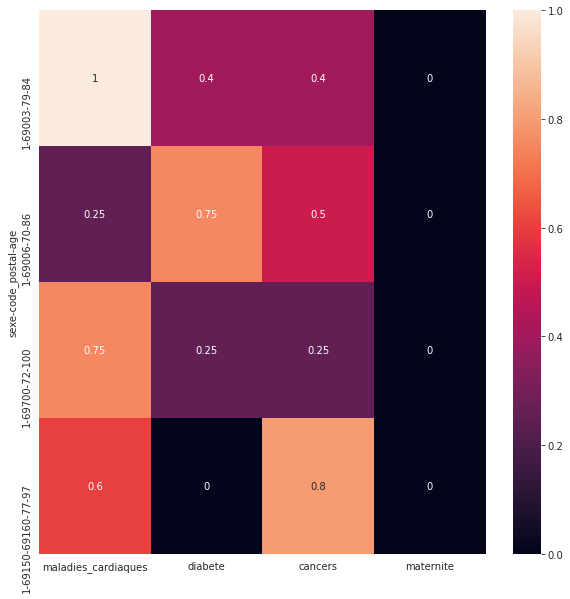

In [53]:
df_hm = df_k_anonymised.groupby(['sexe', 'code_postal', 'age'])[sensitive_columns].mean()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df_hm[(df_hm >= 0.7).any(axis=1)], ax=ax, annot=True)

In [54]:
def plot_mondrian(df, df_k_anonym):
    fig, ax = plt.subplots(figsize=(20, 10))
    df_plot = df\
                .groupby(['age', 'code_postal'])\
                .size()\
                .to_frame()\
                .reset_index()\
                .rename(columns={0: 'n_patients'})

    sc = ax.scatter(x=df_plot.age, y=df_plot.code_postal, s=15, c=df_plot.n_patients, cmap='hot')

    for (age, code_postal), dfx in df_k_anonym.groupby(['age', 'code_postal']):
        if '-' in str(age):
            age_min, age_max = map(int, age.split('-'))
        else:
            age = int(age)
            age_min, age_max = age, age

        age_min -= 0.5
        age_max += 0.5

        if '-' in str(code_postal):
            code_postal_min, code_postal_max = map(lambda x: int(x), code_postal.split('-'))
            code_postal_jitter = .5
        else:
            code_postal = int(code_postal)
            code_postal_min, code_postal_max  = code_postal, code_postal
            code_postal_jitter = .01 * (code_postal - 69000)
        
        code_postal_min -= code_postal_jitter
        code_postal_max += code_postal_jitter

        rect = ax.add_patch(
        patches.Rectangle(
            (age_min, code_postal_min),
            age_max - age_min,
            code_postal_max - code_postal_min,
            facecolor = 'red',
            edgecolor='red',
            fill=True,
            alpha=0.2
         ) )

    # ax.set_yscale('log')
    fig.colorbar(sc, ax=ax)

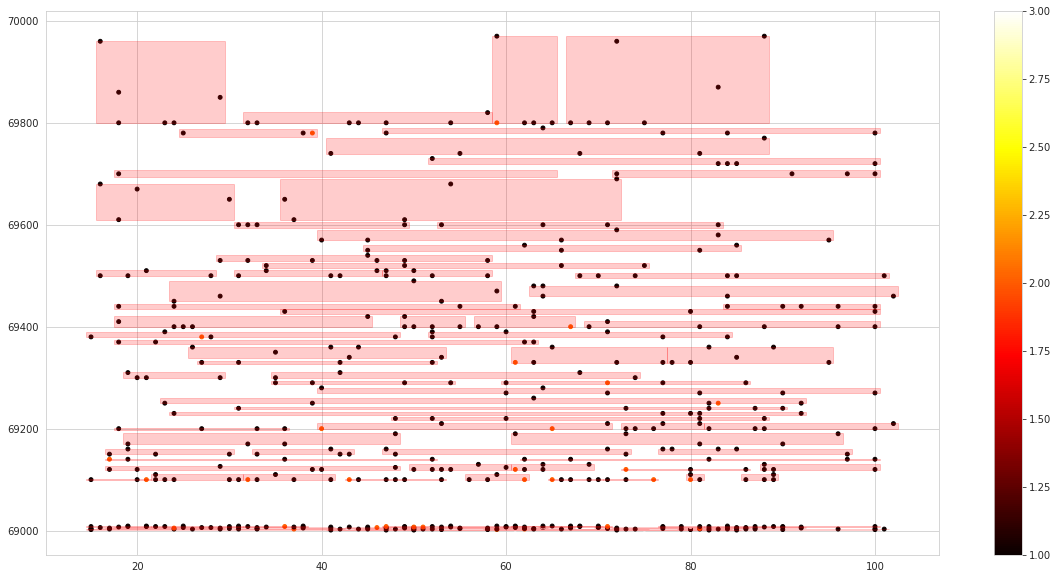

In [55]:
plot_mondrian(df_sdata_h, df_k_anonymised_h)

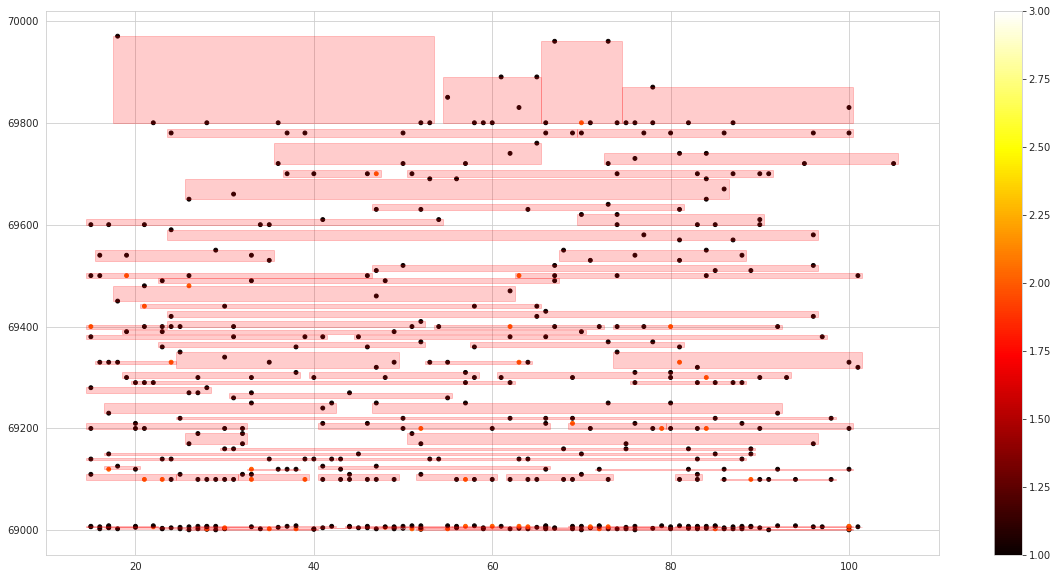

In [56]:
plot_mondrian(df_sdata_f, df_k_anonymised_f)